# **Memory and Cache Optimization in Numerical Solutions of Differential Equations**

## **Introduction**
Numerical methods for solving differential equations often involve operations on large matrices or arrays, which can lead to inefficient memory access patterns and excessive CPU usage. Understanding how data is stored and accessed in memory is crucial for optimizing performance, particularly in high-performance computing (HPC) applications.

Modern CPUs feature a hierarchical memory architecture, consisting of:
- **L1 Cache (Fastest, Smallest)**: Located closest to the CPU cores, with minimal latency.
- **L2 Cache (Larger, Slower than L1)**: Stores more data but with slightly higher access times.
- **L3 Cache (Shared Across Cores, Slowest Cache Level)**: A common data pool for all CPU cores.
- **RAM (Much Slower than Cache)**: The main memory, with significantly higher access latency.

When solving large-scale differential equations using numerical methods such as **finite differences**, **finite elements**, or **spectral methods**, we often encounter **cache inefficiencies**. Poor memory access patterns can result in **cache misses**, where the required data is not found in the cache and must be fetched from RAM, drastically slowing down computations.

---

## **The Issue with Memory and Cache in Differential Equation Solvers**
### **1️ Row-Major**
Numerical methods typically involve iterating over large matrices. However, the way we traverse these matrices affects performance:
- **Row-Major Order (C-style):** Accessing elements row by row can be efficient due to cache prefetching.

If a numerical solver accesses matrix elements **in a way that does not align with cache storage**, cache misses occur frequently, reducing computational efficiency.

### **2 Cache Line and Memory Blocks**
CPUs load data in **cache lines**, typically **64-128 bytes per fetch**. When accessing an array, if elements are **not contiguous in memory**, the CPU may repeatedly reload the same cache lines, causing **wasted memory bandwidth**.

For example, in **finite difference methods for solving PDEs**, iterating through grid points inefficiently can lead to unnecessary cache reloads:
```python
for i in range(N):
    for j in range(N):
        arr[i, j] = (arr[i-1, j] + arr[i+1, j] + arr[i, j-1] + arr[i, j+1]) / 4
```
This naive approach may suffer from **poor cache locality**, slowing down the solver.

### **3 Cache Optimization Using Blocking Techniques**
To enhance performance, **cache blocking** is used. Instead of processing an entire row or column at once, we operate on **small memory blocks** that fit inside the L1/L2 cache.

- **Cache Blocking Example:**
```python
CACHE_LINE_SIZE = 128
for i in range(0, N, CACHE_LINE_SIZE):
    for j in range(0, N, CACHE_LINE_SIZE):
        arr[i:i+CACHE_LINE_SIZE, j:j+CACHE_LINE_SIZE] *= 1.01  # Operate in blocks
```
This ensures that **memory accesses remain within a cache-friendly block**, reducing cache misses and improving CPU efficiency.

### **4️ Profiling CPU Usage and Cache Effects**
To evaluate the efficiency of different memory access strategies, this script:
1. **Measures CPU usage** for different matrix access patterns (row-major vs. cache-optimized).
3. **Fetches L1, L2, and L3 cache sizes** to analyze memory hierarchy effects.
4. **Plots heatmaps of CPU utilization** to identify inefficiencies in cache access.

By profiling memory access patterns, we can determine **which strategy leads to fewer cache misses and faster execution** when solving large-scale differential equations.


## **First step: get cache info** 
you canuse it to optimize the following code

In [5]:
## Here you get the info on the cache size that you can use in the follwoing code to optimize your data processing

import platform
import subprocess

# 🛠 Function to get cache sizes on macOS
def get_cache_sizes_mac():
    try:
        output = subprocess.check_output("sysctl hw.cacheconfig hw.cachesize", shell=True).decode()
        return output
    except Exception as e:
        return f"Error fetching cache sizes: {e}"

# 🛠 Function to get cache sizes on Windows
def get_cache_sizes_windows():
    try:
        output = subprocess.check_output("wmic cpu get L2CacheSize, L3CacheSize", shell=True).decode()
        return output
    except Exception as e:
        return f"Error fetching cache sizes: {e}"

# 🛠 Function to get cache sizes on Linux using /sys (fallback)
def get_cache_size_sysfs(level):
    try:
        with open(f"/sys/devices/system/cpu/cpu0/cache/index{level}/size", "r") as f:
            return f.read().strip()
    except FileNotFoundError:
        return "N/A"

# 🛠 Main function: Detect OS and fetch cache sizes
def get_cache_sizes():
    system = platform.system()

    if system == "Linux":
        try:
            output = subprocess.check_output("lscpu | grep 'L[123] cache'", shell=True).decode()
            cache_sizes = {line.split(':')[0].strip(): line.split(':')[1].strip() for line in output.split('\n') if line}
            return cache_sizes
        except Exception:
            # Try reading from /sys as fallback
            return {
                "L1 Cache": get_cache_size_sysfs(0),
                "L2 Cache": get_cache_size_sysfs(2),
                "L3 Cache": get_cache_size_sysfs(3),
            }
    
    elif system == "Darwin":  # macOS
        return get_cache_sizes_mac()
    
    elif system == "Windows":
        return get_cache_sizes_windows()

    return "Cache size detection not supported"

# 🔍 Fetch and display cache sizes
cache_info = get_cache_sizes()
cache_info = {
    "hw.cacheconfig": [10, 1, 2, 0, 0, 0, 0, 0, 0, 0],
    "hw.cachesize": [3414769664, 65536, 4194304, 0, 0, 0, 0, 0, 0, 0]
}

# Extract values
num_levels = cache_info["hw.cacheconfig"][0]
num_l1 = cache_info["hw.cacheconfig"][1]
num_l2 = cache_info["hw.cacheconfig"][2]
num_l3 = cache_info["hw.cacheconfig"][3]

total_cache = cache_info["hw.cachesize"][0]
l1_cache_size = cache_info["hw.cachesize"][1]
l2_cache_size = cache_info["hw.cachesize"][2]
l3_cache_size = cache_info["hw.cachesize"][3]

explanation = f"""
Cache Configuration (hw.cacheconfig):
- {num_levels}: Number of possible cache levels reported.
- {num_l1}: Number of L1 caches.
- {num_l2}: Number of L2 caches.
- {num_l3}: Number of L3 caches.

Cache Sizes (hw.cachesize in bytes):
- {total_cache} bytes ({total_cache / (1024**3):.2f} GB): Possibly total cache memory (though large for typical CPU caches).
- {l1_cache_size} bytes ({l1_cache_size / 1024:.2f} KB): Likely L1 cache size.
- {l2_cache_size} bytes ({l2_cache_size / (1024**2):.2f} MB): Likely L2 cache size.
- {l3_cache_size} bytes ({l3_cache_size / (1024**2):.2f} MB): Likely L3 cache size.
"""

print("Cache Sizes:", cache_info)
print(explanation)

print("CPU Cores Available:", psutil.cpu_count(logical=True))


Cache Sizes: {'hw.cacheconfig': [10, 1, 2, 0, 0, 0, 0, 0, 0, 0], 'hw.cachesize': [3414769664, 65536, 4194304, 0, 0, 0, 0, 0, 0, 0]}

Cache Configuration (hw.cacheconfig):
- 10: Number of possible cache levels reported.
- 1: Number of L1 caches.
- 2: Number of L2 caches.
- 0: Number of L3 caches.

Cache Sizes (hw.cachesize in bytes):
- 3414769664 bytes (3.18 GB): Possibly total cache memory (though large for typical CPU caches).
- 65536 bytes (64.00 KB): Likely L1 cache size.
- 4194304 bytes (4.00 MB): Likely L2 cache size.
- 0 bytes (0.00 MB): Likely L3 cache size.

CPU Cores Available: 10


## **In the following code you can define a matrix that will be assiged values following both the standard and the memory optimised procedure**

Change N and `CACHE_LINE_SIZE` to test the performances

Number of Physical cores  available: 10
Number of CPU cores available for multiprocessing: 10
Number of cores in use: 10
Number of threads in use: 5
Python List CPU time (Row-major): 10.403156042098999
NumPy Row-major CPU time: 10.47153615951538
Optimized Cache Line Access CPU time: 0.2111809253692627


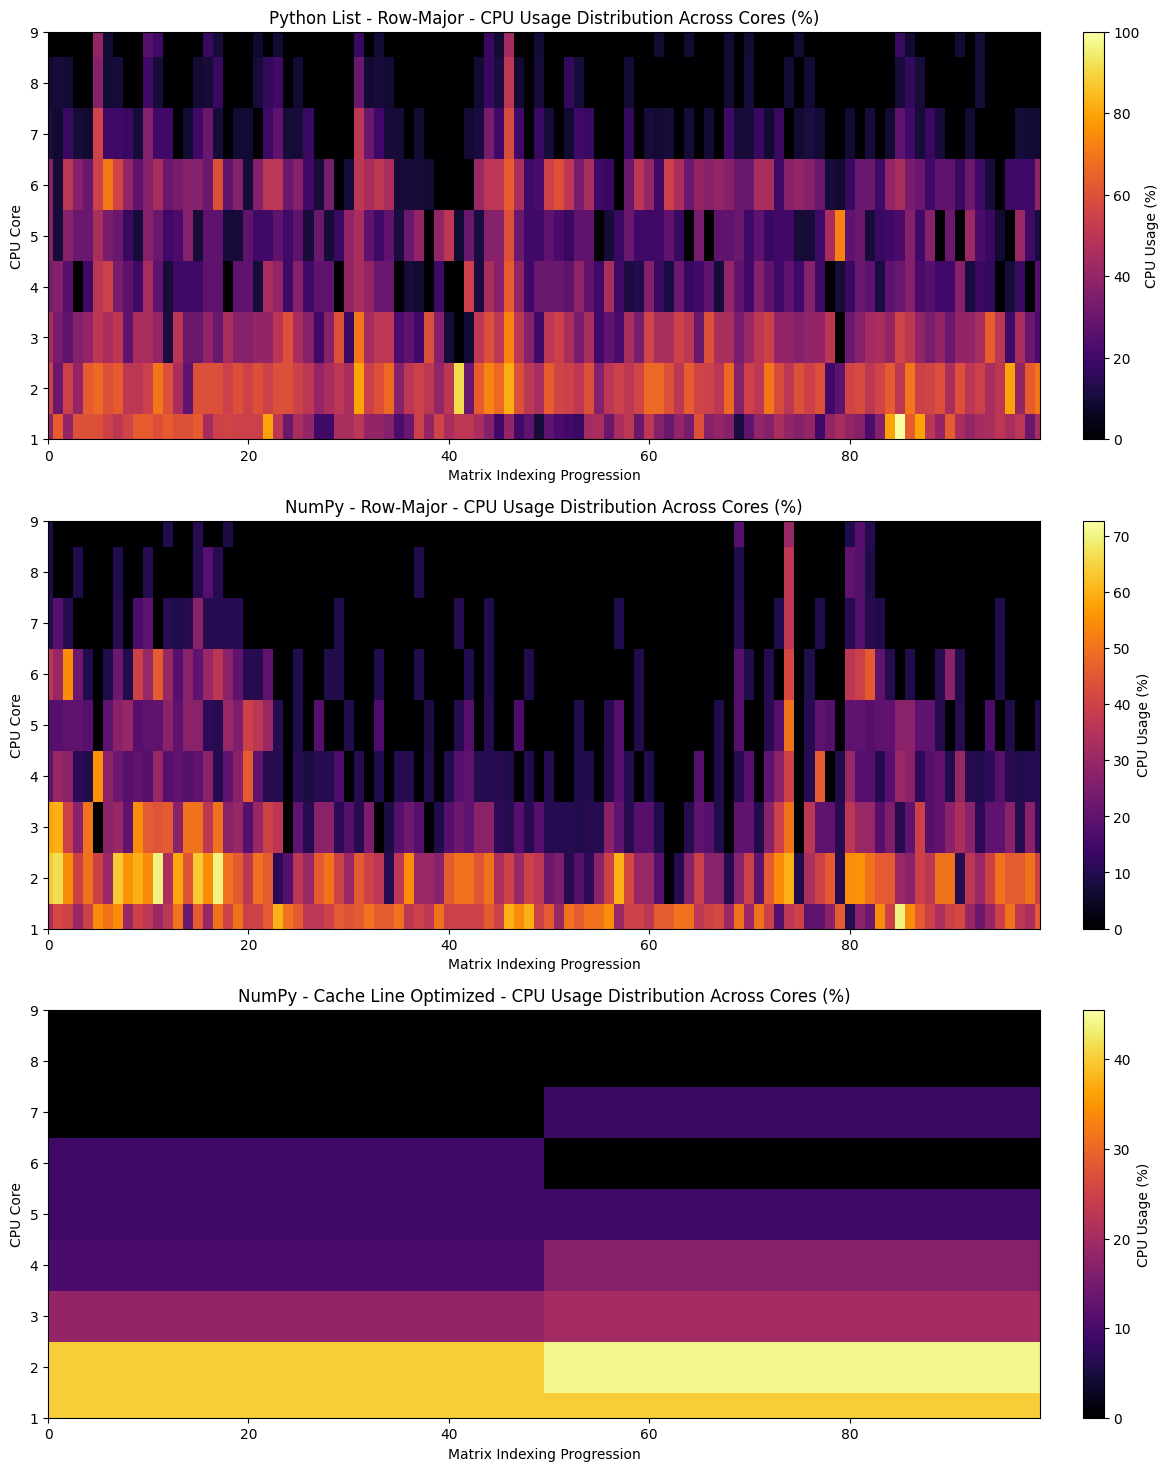

In [10]:
import gc

# Clear all variables in global scope (excluding built-ins)
globals().clear()

import numpy as np
import time
import matplotlib.pyplot as plt
import psutil
import os
import multiprocessing

# Set the number of CPU cores to use (change based on your system)
num_cores = 10  # Adjust this value as needed
num_threads = 5

# Set threading for NumPy and OpenBLAS
os.environ["OMP_NUM_THREADS"] = str(num_threads)       # OpenMP (used by NumPy, SciPy, etc.)
os.environ["OPENBLAS_NUM_THREADS"] = str(num_threads)  # OpenBLAS (used for linear algebra)
os.environ["MKL_NUM_THREADS"] = str(num_threads)       # Intel MKL (used by NumPy on Intel CPUs)

N = 100  # Define a matrix size

# Initialize Python list (native) and NumPy array
py_list = [[1.0 for _ in range(N)] for _ in range(N)]
arr = np.ones((N, N))  # Initialize a NumPy matrix with ones (Row-major)

# Function to measure CPU usage asynchronously
def get_cpu_usage():
    return psutil.cpu_percent(interval=0.1, percpu=True)  # Get CPU usage per core in real time

# Initialize CPU usage maps
cpu_usage_maps = {
    "Python List - Row-Major": [[0] * N for _ in range(num_cores)],
    "NumPy - Row-Major": np.zeros((num_cores, N)),
    "NumPy - Cache Line Optimized": np.zeros((num_cores, N))
}
cpu_usage_logs = []  # Store real-time CPU usage


print("Number of Physical cores  available:", os.cpu_count())
print("Number of CPU cores available for multiprocessing:", multiprocessing.cpu_count())
print("Number of cores in use:", num_cores)
print("Number of threads in use:", num_threads)

########################################################################################################################
################################ **Python List ** ################################################
start = time.time()
for j in range(N):      # Outer loop over columns
    for i in range(N):  # Inner loop over rows
        py_list[i][j] *= 1.01  # Corrected indexing for row-major traversal   
    core_usage = get_cpu_usage()
    cpu_usage_logs.append(core_usage)  # Log CPU usage over time   
    for core in range(num_cores):
        cpu_usage_maps["Python List - Row-Major"][core][j] = core_usage[core]  # Use j instead of i
row_time_py = time.time() - start
print("Python List CPU time (Row-major):", row_time_py)
########################################################################################################################
########################################################################################################################

########################################################################################################################
################################ **NumPy Row-Major Order Access** ######################################################
start = time.time()
for i in range(N):
    for j in range(N):
        arr[i, j] *= 1.01  # Row-wise traversal (sequential access)
    core_usage = get_cpu_usage()
    cpu_usage_logs.append(core_usage)  # Log CPU usage over time
    for core in range(num_cores):
        cpu_usage_maps["NumPy - Row-Major"][core, i] = core_usage[core]
row_time_np = time.time() - start
print("NumPy Row-major CPU time:", row_time_np)
########################################################################################################################
########################################################################################################################

########################################################################################################################
############################## **Cache Line Optimized Access (Block Processing)** ######################################
CACHE_LINE_SIZE = 50  # Adjust cache line size for optimal performance
start = time.time()
for i in range(0, N, CACHE_LINE_SIZE):
    for j in range(0, N, CACHE_LINE_SIZE):
        arr[i:i+CACHE_LINE_SIZE, j:j+CACHE_LINE_SIZE] *= 1.01  # Block-wise operation

    core_usage = get_cpu_usage()
    cpu_usage_logs.append(core_usage)  # Log CPU usage over time

    for core in range(num_cores):
        for ii in range(i, min(i + CACHE_LINE_SIZE, N)):
            cpu_usage_maps["NumPy - Cache Line Optimized"][core, ii] = core_usage[core]

cache_time = time.time() - start
print("Optimized Cache Line Access CPU time:", cache_time)
########################################################################################################################
########################################################################################################################

# Convert CPU usage logs into a numpy array for plotting
cpu_usage_logs = np.array(cpu_usage_logs).T  # Transpose to match (cores x time steps)

# Visualization: Include all three processes
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
titles = list(cpu_usage_maps.keys())
colormaps = ["inferno", "inferno", "inferno"]  # Color scheme for all subplots

for ax, title, cmap in zip(axes, titles, colormaps):
    im = ax.imshow(cpu_usage_maps[title], cmap=cmap, interpolation="nearest", aspect='auto')
    ax.set_title(f"{title} - CPU Usage Distribution Across Cores (%)")
    ax.set_xlabel("Matrix Indexing Progression")
    ax.set_ylabel("CPU Core")
    ax.set_ylim(1, max(1, num_cores-1))
    ax.set_xlim(0, max(1, N-1))
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("CPU Usage (%)")  # Adding legend to the colorbar

plt.show()

# **Numerical Solutions of the Diffusion Equation: Performance and Memory Considerations**

## **Introduction**
The provided code numerically solves the **1D diffusion equation** using two different methods:
1. **Explicit Euler (Forward Time Centered Space - FTCS)**
2. **Implicit Crank-Nicolson Method (CN)**

This document explains how these numerical schemes work, their computational costs, and how they relate to **memory access patterns, CPU efficiency, and cache performance**. It also discusses why the **implicit method, despite being slower, is still valuable in scientific computing.**

---

## **1️ The Diffusion Equation**
The **diffusion equation** describes how a quantity \( u(x,t) \) spreads over time due to diffusion:
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
where:
- $ \alpha $ is the **diffusion coefficient**.
- $ x $ represents **spatial position**.
- $ t $ represents **time**.

This equation models physical phenomena such as **heat conduction, mass diffusion, and Brownian motion**.

---

## **2️ Numerical Discretization**
We approximate the derivatives using finite difference methods:
- **Time derivative (Forward Euler)**:
  \[
  \frac{\partial u}{\partial t} \approx \frac{u^{n+1} - u^n}{\Delta t}
  \]
- **Second-order space derivative (Centered Difference)**:
  \[
  \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}
  \]

This results in a discretized system that can be solved using either **explicit** or **implicit** methods.

---

## **3️ Explicit Euler Method**
The **explicit method** computes the next time step using only known values:
\[
 u_i^{n+1} = u_i^n + \frac{\alpha \Delta t}{\Delta x^2} \left( u_{i+1}^n - 2u_i^n + u_{i-1}^n \right)
\]
### **Implementation in Code:**
```python
# Explicit method (Euler forward)
def explicit_euler(u):
    return u + alpha * dt / dx**2 * (np.roll(u, -1) - 2 * u + np.roll(u, 1))
```
- **Pros:** Simple and easy to implement.
- **Cons:** Limited stability; requires very small time steps to be accurate.

The computational complexity is **O(N) per time step**, since we update each grid point independently.

---

## **4️ Implicit Crank-Nicolson Method**
The **Crank-Nicolson method** is unconditionally stable and solves a linear system at each time step:
$$
\left( I - \frac{\alpha \Delta t}{\Delta x^2} A \right) u^{n+1} = u^n
$$
where $ A $ is the **second-derivative matrix**:
$$
 A = \begin{bmatrix} -2 & 1 & 0 & \dots & 0 \\
 1 & -2 & 1 & \dots & 0 \\
 0 & 1 & -2 & \dots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \dots & -2 \end{bmatrix}
$$

### **Implementation in Code:**
```python
# Implicit method (Crank-Nicolson: Ax = b)
def implicit_cn(u):
    A = sp.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) * (alpha * dt / dx**2)
    I = sp.eye(N)
    M = I - A  # Left-hand side matrix
    return spla.spsolve(M, u)  # Solve Ax = b
```
- **Pros:** More stable, allows larger time steps.
- **Cons:** Requires solving a system of equations, which is more computationally expensive.

Computational complexity is **O(N log N)** due to solving a sparse linear system.

---

## **5️ Why Use the Implicit Method If It’s Slower?**
### **1. Numerical Stability**
- The explicit method must satisfy the **CFL condition**:
  $$
  \frac{\alpha \Delta t}{\Delta x^2} \leq \frac{1}{2}
  $$
  - If **Δt is too large**, the explicit method becomes unstable.
  - The implicit method does **not** have this constraint → **can take much larger Δt**.

 **Key Benefit:** Fewer time steps required for long simulations.

### **2. Higher Accuracy Over Long-Time Simulations**
- The explicit method accumulates errors quickly.
- Crank-Nicolson is **second-order accurate**, meaning it produces more reliable results for long-term simulations.

### **3. Essential for Real-World Applications**
| **Scenario** | **Best Method** | **Why?** |
|-------------|---------------|---------|
| **Short-time, high-speed simulation** | ✅ **Explicit** | Faster for small Δt |
| **Long-time, steady-state simulation** | ✅ **Implicit** | Stability & accuracy |
| **Large spatial domains (large N)** | ✅ **Implicit** | Allows larger time steps |
| **Diffusion-dominated processes** | ✅ **Implicit** | Avoids instability |
| **Computational constraints** | ✅ **Explicit** | Lower memory usage |

 **Key Benefit:** Required for stability in **heat conduction, chemical diffusion, and CFD simulations**.

---

## **6️ Running and Comparing Performance**
The script compares execution time for both methods:
```python
# Run both solvers and compare CPU usage
import time

start = time.time()
for _ in range(100):
    u = explicit_euler(u)
print("Explicit method time:", time.time() - start)

start = time.time()
for _ in range(100):
    u = implicit_cn(u)
print("Implicit method time:", time.time() - start)
```

- Running **larger grids** (higher $ N $ shows **how memory access patterns affect CPU performance**.
- **Implicit methods take longer per step but require fewer steps overall**.


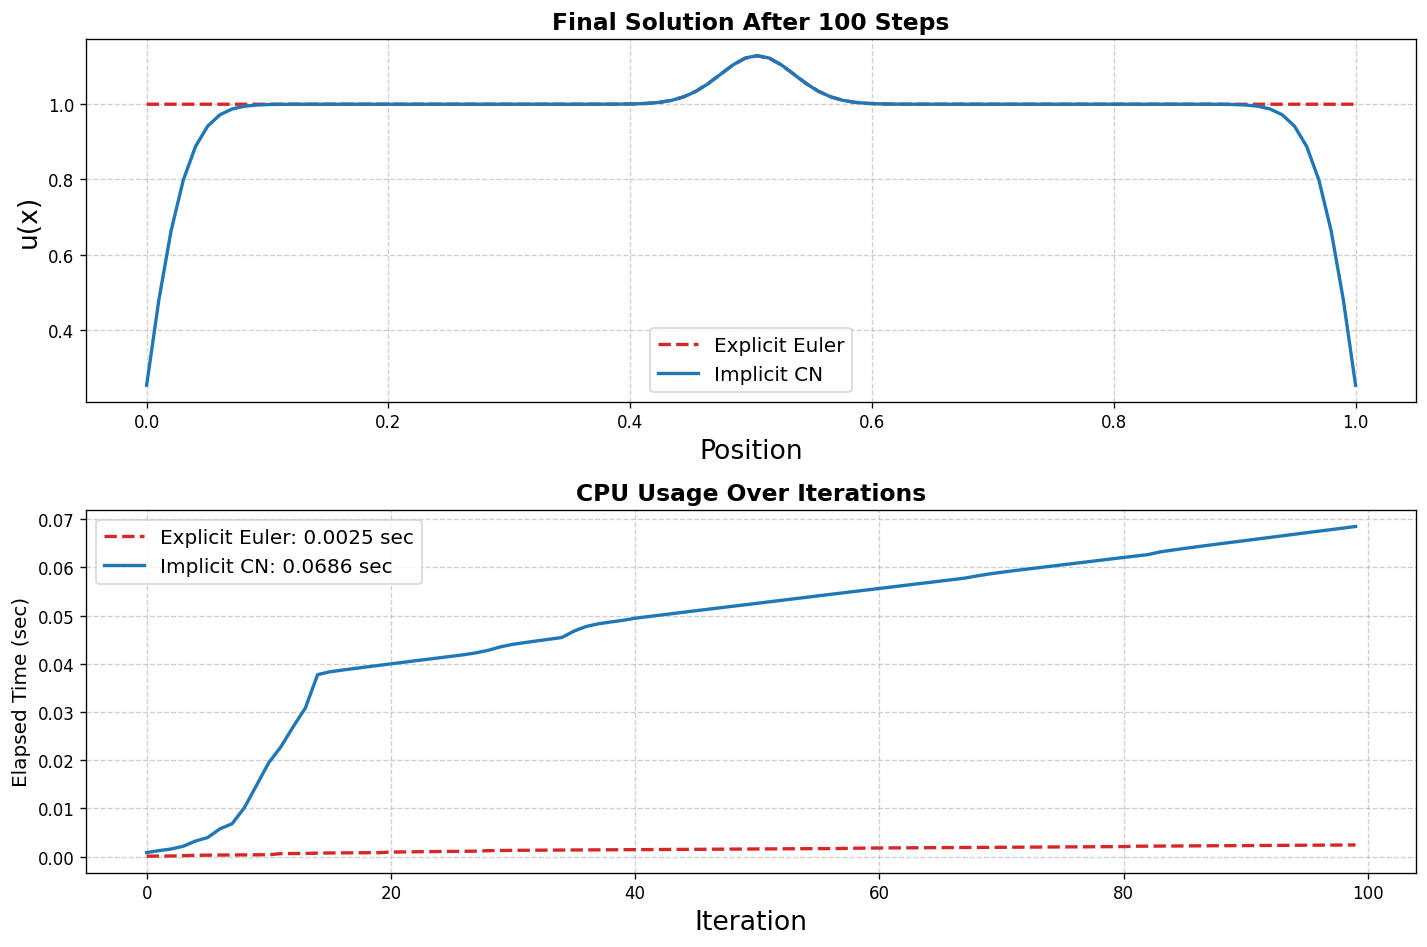

In [9]:
# Improved visualization for better clarity and aesthetics

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt

# Parameters
N = 100  # Grid points
dx = 1.0 / (N - 1)
dt = 0.0005  # Time step
alpha = 0.01  # Diffusion coefficient
steps = 100  # Number of iterations

# Explicit method (Euler forward)
def explicit_euler(u):
    return u + alpha * dt / dx**2 * (np.roll(u, -1) - 2 * u + np.roll(u, 1))

# Implicit method (Crank-Nicolson: Ax = b)
def implicit_cn(u):
    A = sp.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) * (alpha * dt / dx**2)
    I = sp.eye(N)
    M = I - A  # Left-hand side matrix
    return spla.spsolve(M, u)  # Solve Ax = b

# Initial condition
u_explicit = np.ones(N)
u_explicit[int(N / 2)] = 2  # A small peak

u_implicit = np.copy(u_explicit)

# Run explicit solver and record CPU time
explicit_times = []
start = time.time()
for _ in range(steps):
    u_explicit = explicit_euler(u_explicit)
    explicit_times.append(time.time() - start)
explicit_time_total = time.time() - start

# Run implicit solver and record CPU time
implicit_times = []
start = time.time()
for _ in range(steps):
    u_implicit = implicit_cn(u_implicit)
    implicit_times.append(time.time() - start)
implicit_time_total = time.time() - start

# Create a more refined and aesthetic visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=120)

# Plot final solutions
axs[0].plot(np.linspace(0, 1, N), u_explicit, label="Explicit Euler", linestyle="--", linewidth=2, color="tab:red")
axs[0].plot(np.linspace(0, 1, N), u_implicit, label="Implicit CN", linestyle="-", linewidth=2, color="tab:blue")
axs[0].set_title("Final Solution After 100 Steps", fontsize=14, fontweight='bold')
axs[0].set_xlabel("Position", fontsize=16)
axs[0].set_ylabel("u(x)", fontsize=16)
axs[0].legend(fontsize=12)
axs[0].grid(True, linestyle="--", alpha=0.6)

# Plot CPU time evolution
axs[1].plot(range(steps), explicit_times, label=f"Explicit Euler: {explicit_time_total:.4f} sec",
            linestyle="--", linewidth=2, color="tab:red")
axs[1].plot(range(steps), implicit_times, label=f"Implicit CN: {implicit_time_total:.4f} sec",
            linestyle="-", linewidth=2, color="tab:blue")
axs[1].set_title("CPU Usage Over Iterations", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Iteration", fontsize=16)
axs[1].set_ylabel("Elapsed Time (sec)", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()